In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from scipy.stats import kstest

In [2]:
velocity_M1 = pd.read_csv('data/M1V.csv', index_col = 0)
velocity_M1.index = pd.to_datetime(velocity_M1.index)

velocity_M2 = pd.read_csv('data/M2V.csv', index_col = 0)
velocity_M2.index = pd.to_datetime(velocity_M2.index)

# velocity_M1 = velocity_M1.resample('m').mean().loc[:'2018']
# velocity_M2 = velocity_M2.resample('m').mean().loc[:'2018']

In [3]:
mkt_cap = pd.read_csv('data/market_cap_usa.csv', sep = ';')
mkt_cap = mkt_cap.T.loc['1980':'2018']
mkt_cap.columns = ['MktCap']
mkt_cap.index = pd.to_datetime(mkt_cap.index)
mkt_cap['MktCap'] = mkt_cap['MktCap'].astype(float)

In [4]:
mkt_cap_wilshire = pd.read_csv('data/wilshire_marketcap_index.csv', index_col = 0)
mkt_cap_wilshire = mkt_cap_wilshire.loc['1980':'2018']
mkt_cap_wilshire.columns = ['MktCap']
mkt_cap_wilshire.index = pd.to_datetime(mkt_cap_wilshire.index)
mkt_cap_wilshire.replace('.', np.nan, inplace = True)
mkt_cap_wilshire['MktCap'] = mkt_cap_wilshire['MktCap'].astype(float)

mkt_cap_wilshire = mkt_cap_wilshire.resample('m').first()
mkt_cap_wilshire

,MktCap
DATE,
1980-04-30,1.77
1980-05-31,1.86
1980-06-30,1.98
1980-07-31,2.07
1980-08-31,2.20
...,...
2017-08-31,113.90
2017-09-30,114.08
2017-10-31,117.04


In [5]:
m2_data = pd.read_csv('data/M2_money_stock.csv', index_col = 0)
m1_data = pd.read_csv('data/M1_money_stock.csv', index_col = 0)
m0_data = pd.read_csv('data/monetary_base_curr_in_circulation.csv', index_col = 0)
gdp_data = pd.read_csv('data/GDP.csv', index_col = 0)

m2_data.index = pd.to_datetime(m2_data.index)
m2_data.columns = ['M2']
m2_data = m2_data.resample('m').mean().loc[:'2018']

m1_data.index = pd.to_datetime(m1_data.index)
m1_data.columns = ['M1']
m1_data = m1_data.resample('m').mean().loc[:'2018']

m0_data.index = pd.to_datetime(m0_data.index)
m0_data.columns = ['M0']
m0_data = m0_data.resample('m').mean().loc[:'2018']

gdp_data.index = pd.to_datetime(gdp_data.index)
gdp_data.columns = ['GDP']
# gdp_data = gdp_data.resample('Y').mean().loc[:'2018']

In [35]:
inflation_data = pd.read_csv('data/CPIAUCSL.csv', index_col = 0)
inflation_data.index = pd.to_datetime(inflation_data.index)
inflation_data.columns = ['inflation']
# inflation_data = inflation_data.pct_change()
# inflation_data = inflation_data.dropna()

In [36]:
# inflation_data_r = inflation_data.resample('Y').last()

In [37]:
test_data = inflation_data.join(mkt_cap_wilshire, how = 'outer')
test_data['inflation'] = test_data['inflation'].fillna(method = 'bfill')
test_data = test_data.dropna()

test_data = test_data.join(m2_data)
test_data = test_data.join(m1_data)
test_data = test_data.join(m0_data)
test_data = test_data.join(gdp_data, how = 'outer')
test_data[['inflation', 'MktCap', 'M2', 'M1', 'M0']] = test_data[['inflation', 'MktCap', 'M2', 'M1', 'M0']].fillna(method = 'ffill')
test_data.dropna(inplace = True)
test_data = test_data.join(velocity_M1)
test_data = test_data.join(velocity_M2)

In [9]:
granger_test_data = inflation_data.join(mkt_cap_wilshire, how = 'outer')
granger_test_data['inflation'] = granger_test_data['inflation'].fillna(method = 'bfill')
granger_test_data = granger_test_data.dropna()

print(granger_test_data.head(5))

            inflation  MktCap
DATE                         
1980-04-30   0.009889    1.77
1980-05-31   0.009792    1.86
1980-06-30   0.001212    1.98
1980-07-31   0.007264    2.07
1980-08-31   0.008413    2.20


In [10]:
test_data = test_data.loc[:'2017']

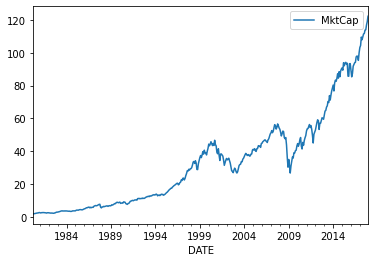

In [11]:
mkt_cap_wilshire.plot()
plt.show()

In [12]:
test_data.tail(3)

,inflation,MktCap,M2,M1,M0,GDP,M1V,M2V
DATE,,,,,,,,
2017-04-01,0.002084,109.63,13488.125,3441.25,1530000.0,19379.232,5.545,1.432
2017-07-01,0.000254,111.53,13527.225,3506.60,1556200.0,19617.288,5.508,1.435
2017-10-01,0.000430,114.08,13704.075,3535.60,1578800.0,19937.963,5.512,1.444


In [38]:
test_data_log_diff = np.log(test_data) - np.log(test_data).shift(1)
test_data_log_diff = test_data_log_diff.dropna()
for col in test_data_log_diff.columns:
    print(col, adfuller(test_data_log_diff[col].values)[1])

inflation 0.004354818906595123
MktCap 3.0876472736479394e-23
M2 0.0398063926799929
M1 0.06901738496450373
M0 0.22516345759665535
GDP 1.2945593016588255e-24
M1V 1.758658376189599e-17
M2V 1.5895655063389353e-20


In [14]:
test_data_log_diff['MktCap'].tail(10)

DATE
2013-10-01    0.012435
2014-01-01    0.098484
2014-04-01    0.039304
2014-07-01    0.032146
2015-07-01    0.002763
2015-10-01   -0.093730
2017-01-01    0.020397
2017-04-01    0.091441
2017-07-01    0.017183
2017-10-01    0.022606
Name: MktCap, dtype: float64

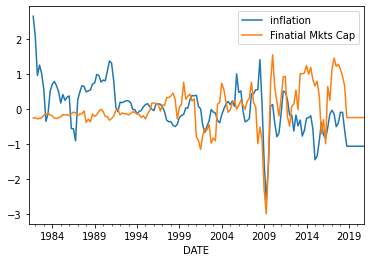

In [161]:
infl = test_data['inflation'].pct_change().dropna()
mkt = test_data['MktCap'].diff().dropna()

infl = ((infl-infl.mean())/infl.std()).rolling(window = 3).mean()
mkt = ((mkt-mkt.mean())/mkt.std()).rolling(window =3).mean()

infl.plot(label = 'inflation')
mkt.plot(label = 'Finatial Mkts Cap')
plt.legend()

## Cointegration Test

### Engle-Granger Method

In [226]:
infl = test_data['inflation']
mkt = test_data.loc[infl.index]['MktCap']

In [184]:
i = 0
while True:
    if adfuller(infl.values)[1] < 0.05:
        print('Order of the Inflation series is:', i)
        break
    else:
        infl = infl.diff().dropna()
    i += 1
    
j = 0
while True:
    if adfuller(mkt.values)[1] < 0.05:
        print('Order of the MktCap series is:', j)
        break
    else:
        mkt = mkt.diff().dropna()
    j += 1
    
infl = test_data['inflation']
mkt = test_data.loc[infl.index]['MktCap']

Order of the Inflation series is: 1
Order of the MktCap series is: 1


In [237]:
model = sm.OLS(infl.values, mkt.values)
results = model.fit()

residuals = infl.values - results.predict()
adfuller_pvalue = adfuller(residuals)[1]
print('Engle-Granger pvalue for cointegration:', adfuller_pvalue)

residuals = np.diff(residuals,1)
adfuller_pvalue = adfuller(residuals)[1]
print('Engle-Granger pvalue for cointegration order one:', adfuller_pvalue)

Engle-Granger pvalue for cointegration: 0.9959499189523608
Engle-Granger pvalue for cointegration order one: 1.4485369271231046e-06


In [242]:
infl = infl.diff().dropna()
mkt = mkt.diff().dropna()

mkt = sm.add_constant(mkt)

model = sm.OLS(infl, mkt)
results = model.fit()

hypotheses = 'MktCap = 0'
print('Parameters')
print(results.params)
print('------------\n')


print('t-statistic')
print(results.tvalues)
print('------------\n')

print('Degrees of Freedom:', mkt.shape[0])
print('------------\n')

residuals = infl.values - results.predict()
print('Normality test result:', kstest(residuals, 'norm')[1])
adfuller_pvalue = adfuller(residuals)[1]
print('p-value for unit root:', adfuller_pvalue)

Parameters
const     0.925405
MktCap    0.120116
dtype: float64
------------

t-statistic
const     11.682656
MktCap     4.787249
dtype: float64
------------

Degrees of Freedom: 159
------------

Normality test result: 0.005646508492077157
p-value for unit root: 6.737005210634891e-19


In [246]:
infl = test_data['inflation']
mkt = test_data.loc[infl.index]['MktCap']
infl = infl.diff().dropna()
mkt = mkt.diff().dropna()

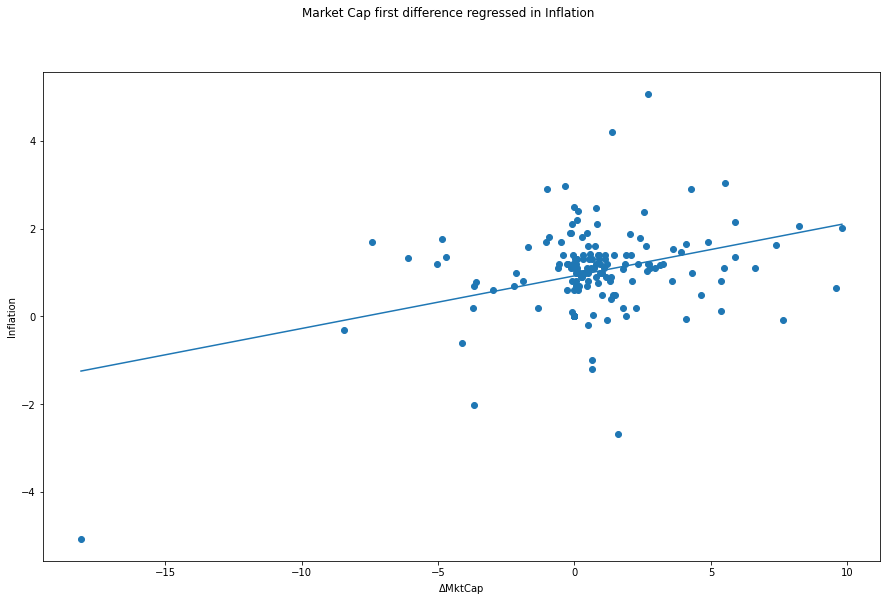

In [261]:
plt.figure(figsize=(15,9))
plt.scatter(mkt.values, infl.values)
plt.plot(np.linspace(start = min(mkt.values), stop = max(mkt.values)), 0.925 + 0.120 * np.linspace(start = min(mkt.values), stop = max(mkt.values)))
plt.xlabel(r'$\Delta$MktCap')
plt.ylabel('Inflation')
plt.suptitle('Market Cap first difference regressed in Inflation')
plt.show()

## Granger Causality

In [16]:
from io import StringIO 
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

In [28]:
a = np.log(granger_test_data['MktCap']) - np.log(granger_test_data['MktCap'].shift(1))
# a = (granger_test_data['MktCap']) - (granger_test_data['MktCap'].shift(1))
a.dropna(inplace = True)
a = pd.DataFrame(a)
a.columns = ['MktCap']
adfuller(a.values)[1]

1.4623821885246671e-28

In [262]:
granger_test_data.shape

(453, 2)

/home/felipe-fp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/felipe-fp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


MktCap 1.4623821885246671e-28
inflation 1.839900868767034e-05


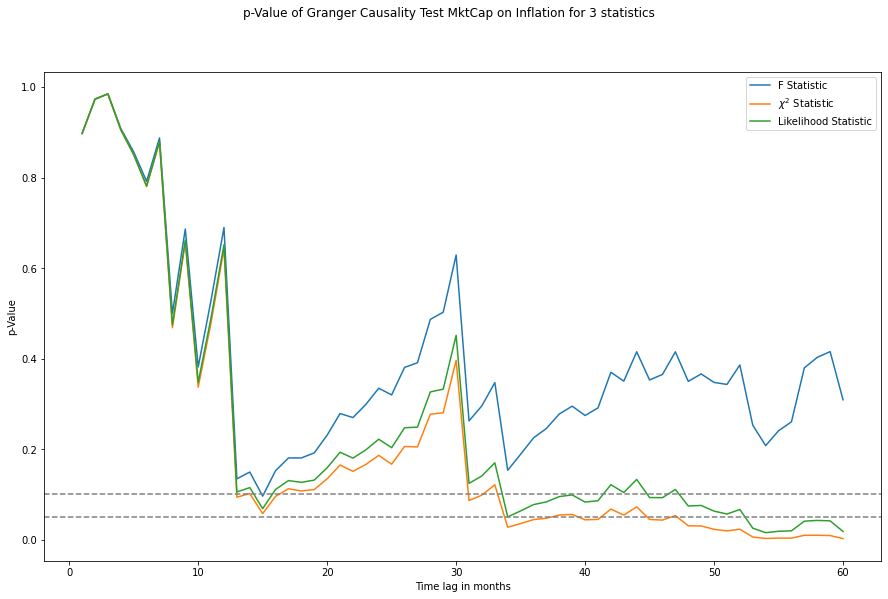

In [234]:
data = np.log(granger_test_data) - (np.log(granger_test_data)).shift(1)
data.dropna(inplace = True)

data = a.join(granger_test_data['inflation'])
# data = data.diff()
# data.dropna(inplace = True)

for col in data.columns:
   print(col, adfuller(data[col].values)[1])

with Capturing() as output:
    grangercausalitytests(data[['inflation','MktCap']], 60)
# print(output)

f_pvalue = []
chi2_pvalue = []
likelihood_pvalue = []

for line in output:
    if line[0:16] == 'ssr based F test':
        f_pvalue.append(float(line[40:46]))
    elif line[0:19] == 'ssr based chi2 test':
        chi2_pvalue.append(float(line[40:46]))
    elif line[0:21] == 'likelihood ratio test':
        likelihood_pvalue.append(float(line[40:46]))

x = [i + 1 for i in range(len(f_pvalue))] 
plt.figure(figsize=(15,9))
plt.plot(x,f_pvalue, label = 'F Statistic')
plt.plot(x,chi2_pvalue, label = r'$\chi^2$ Statistic')
plt.plot(x,likelihood_pvalue, label = 'Likelihood Statistic')
plt.axhline(0.05, color = 'gray', linestyle='--')
plt.axhline(0.1, color = 'gray', linestyle='--')
plt.legend()
plt.xlabel('Time lag in months')
plt.ylabel('p-Value')
plt.suptitle('p-Value of Granger Causality Test MktCap on Inflation for 3 statistics')
plt.show()

In [272]:
df_granger = pd.DataFrame({'Lag':x,'F-statistic p-value':f_pvalue, 'Chi2 statistic p-value':chi2_pvalue})
df_granger = df_granger.set_index('Lag')
display(df_granger)

,F-statistic p-value,Chi2 statistic p-value
Lag,,
1,0.8976,0.8972
2,0.9733,0.9730
3,0.9849,0.9846
4,0.9083,0.9053
5,0.8565,0.8501
6,0.7916,0.7799
7,0.8875,0.8785
8,0.4996,0.4682
9,0.6863,0.6564


In [31]:
grangercausalitytests(data[['inflation','MktCap']], 15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0166  , p=0.8976  , df_denom=448, df_num=1
ssr based chi2 test:   chi2=0.0167  , p=0.8972  , df=1
likelihood ratio test: chi2=0.0167  , p=0.8972  , df=1
parameter F test:         F=0.0166  , p=0.8976  , df_denom=448, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0270  , p=0.9733  , df_denom=445, df_num=2
ssr based chi2 test:   chi2=0.0547  , p=0.9730  , df=2
likelihood ratio test: chi2=0.0547  , p=0.9730  , df=2
parameter F test:         F=0.0270  , p=0.9733  , df_denom=445, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0507  , p=0.9849  , df_denom=442, df_num=3
ssr based chi2 test:   chi2=0.1546  , p=0.9846  , df=3
likelihood ratio test: chi2=0.1546  , p=0.9846  , df=3
parameter F test:         F=0.0507  , p=0.9849  , df_denom=442, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2522  , p=0.9083  

{1: ({'ssr_ftest': (0.01657800348509333, 0.8976088234242361, 448.0, 1),
   'ssr_chi2test': (0.016689016901288153, 0.8972104912006463, 1),
   'lrtest': (0.01668870812500245, 0.8972114368207479, 1),
   'params_ftest': (0.016578003485050025, 0.8976088234243889, 448.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.027048501168462163, 0.9733156336021236, 445.0, 2),
   'ssr_chi2test': (0.05470483382385606, 0.9730182729989123, 2),
   'lrtest': (0.054701508961443324, 0.9730198905761983, 2),
   'params_ftest': (0.02704850116851804, 0.9733156336020514, 445.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.05072731995952695, 0.9848912939559723, 442.0, 3),
   'ssr_chi2test': (0.1545920814151195, 0.9845635549400138, 3),
   'lrtest': (0.15456547425765166, 0.9845674178725636, 3),
   'params_ftest': (0.05072731995951733, 0.9848912939559793, 442.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
        

In [ ]:
data_inv = data[['MktCap', 'inflation']]
gc_res_inv = grangercausalitytests(data_inv, 48)
gc_res_inv

In [235]:
model = VAR(data[['inflation', 'MktCap']])
results = model.fit(36)
results.summary()

/home/felipe-fp/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, May, 2021
Time:                     15:10:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.7082
Nobs:                     416.000    HQIC:                  -17.5634
Log likelihood:           2734.98    FPE:                1.35697e-08
AIC:                     -18.1228    Det(Omega_mle):     9.82061e-09
--------------------------------------------------------------------
Results for equation inflation
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.000683         0.000316            2.159           0.031
L1.inflation          0.510483         0.054136            9.430           0.000
L1.MktCap             0.002760         0.002651         

In [187]:
data = test_data_log_diff[['inflation', 'MktCap']]
gc_test = grangercausalitytests(data,12)
gc_test


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0137  , p=0.3157  , df_denom=143, df_num=1
ssr based chi2 test:   chi2=1.0350  , p=0.3090  , df=1
likelihood ratio test: chi2=1.0313  , p=0.3098  , df=1
parameter F test:         F=1.0137  , p=0.3157  , df_denom=143, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2931  , p=0.7464  , df_denom=140, df_num=2
ssr based chi2 test:   chi2=0.6070  , p=0.7382  , df=2
likelihood ratio test: chi2=0.6058  , p=0.7387  , df=2
parameter F test:         F=0.2931  , p=0.7464  , df_denom=140, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1082  , p=0.9552  , df_denom=137, df_num=3
ssr based chi2 test:   chi2=0.3412  , p=0.9521  , df=3
likelihood ratio test: chi2=0.3408  , p=0.9522  , df=3
parameter F test:         F=0.1082  , p=0.9552  , df_denom=137, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1616  , p=0.9574  

{1: ({'ssr_ftest': (1.0137239892783527, 0.31571297592882475, 143.0, 1),
   'ssr_chi2test': (1.0349909261163601, 0.3089893184307159, 1),
   'lrtest': (1.0313396573633327, 0.30984422827177427, 1),
   'params_ftest': (1.0137239892783279, 0.31571297592883135, 143.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.2930549465415387, 0.746437629448656, 140.0, 2),
   'ssr_chi2test': (0.6070423892646158, 0.7382142427865499, 2),
   'lrtest': (0.6057752334154429, 0.7386821072330363, 2),
   'params_ftest': (0.29305494654155323, 0.7464376294486501, 140.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.1082201559268861, 0.9551718977242664, 137.0, 3),
   'ssr_chi2test': (0.3412489588351445, 0.9520928141484826, 3),
   'lrtest': (0.340845253270345, 0.9521721235254188, 3),
   'params_ftest': (0.10822015592688712, 0.9551718977242664, 137.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

## VAR ANALYSIS

### VAR: inflation, MktCap

In [111]:
def total_squared_error(results, test_data, columns, step):
    observed_inflation = test_data[['inflation']]
    error = []
    for i in range(observed_inflation.shape[0] - step - 1):
        initial_data = (test_data[columns].iloc[i:(i+step),:]).values
        forecast_results = results.forecast(initial_data, 1)[0,0]
        observed_inflation_i = observed_inflation.iloc[i + step + 1].values
        error.append(observed_inflation_i-forecast_results)

    error_norm = np.linalg.norm(error)
    return error_norm

def predict(results, test_data, columns, step):
    observed_inflation = test_data[['inflation']]
    predictions = []
    for i in range(observed_inflation.shape[0] - step - 1):
        initial_data = (test_data[columns].iloc[i:(i+step),:]).values
        forecast_results = results.forecast(initial_data, 1)[0,0]
        predictions.append(forecast_results)
    pred_df = pd.DataFrame(predictions)
    pred_df.index = test_data.index[:observed_inflation.shape[0] - step - 1]
    pred_df.columns = ['prediction']
    return pred_df

In [112]:
model = VAR(test_data_log_diff[['inflation', 'MktCap']])
results = model.fit(4)
results.summary()

/home/felipe-fp/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, May, 2021
Time:                     12:04:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.8702
Nobs:                     155.000    HQIC:                  -15.0801
Log likelihood:           757.962    FPE:                2.44661e-07
AIC:                     -15.2237    Det(Omega_mle):     2.18545e-07
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.003603         0.000931            3.868           0.000
L1.inflation         0.234651         0.085318            2.750           0.006
L1.MktCap           -0.001113         0.005696           -0.

Total Error: 0.07333334403685315


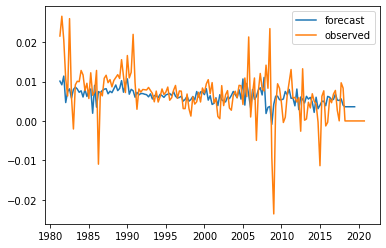

Normality test result: 7.592655688483165e-38


In [113]:
observed_inflation = test_data_log_diff[['inflation']]
step = 4
error = total_squared_error(results,test_data_log_diff, ['inflation', 'MktCap'], step)
print('Total Error:', error)


forecast = predict(results, test_data_log_diff, ['inflation', 'MktCap'], step)
plt.plot(forecast, label = 'forecast')
plt.plot(observed_inflation, label = 'observed')
plt.legend()
plt.show()

residuals = (observed_inflation.values[:observed_inflation.shape[0] - step - 1] - forecast.values)
print('Normality test result:', kstest(residuals, 'norm')[1])

## VAR: inflation, M2, MktCap

In [114]:
model = VAR(test_data_log_diff[['inflation','M2', 'MktCap']])
results = model.fit(4)
results.summary()

/home/felipe-fp/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, May, 2021
Time:                     12:05:45
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.8609
Nobs:                     155.000    HQIC:                  -24.3156
Log likelihood:           1287.76    FPE:                2.01969e-11
AIC:                     -24.6267    Det(Omega_mle):     1.58618e-11
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.002233         0.001275            1.751           0.080
L1.inflation         0.228194         0.086827            2.628           0.009
L1.M2                0.035854         0.052275            0.

Total Error: 0.07311603053838961


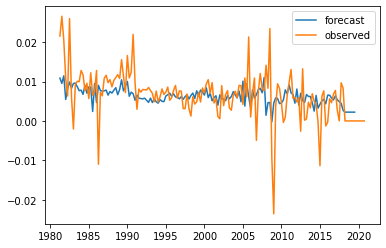

Normality test result: 7.266300019791697e-38


In [115]:
observed_inflation = test_data_log_diff[['inflation']]
step = 4
error = total_squared_error(results,test_data_log_diff, ['inflation','M2', 'MktCap'], step)
print('Total Error:', error)


forecast = predict(results, test_data_log_diff,['inflation','M2', 'MktCap'], step)
plt.plot(forecast, label = 'forecast')
plt.plot(observed_inflation, label = 'observed')
plt.legend()
plt.show()

residuals = (observed_inflation.values[:observed_inflation.shape[0] - step - 1] - forecast.values)
print('Normality test result:', kstest(residuals, 'norm')[1])

## VAR: inflation, M2, GDP, MktCap

In [116]:
model = VAR(test_data_log_diff[['inflation','M2','GDP', 'MktCap']])
results = model.fit(4)
results.summary()

/home/felipe-fp/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, May, 2021
Time:                     12:07:22
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -32.0759
Nobs:                     155.000    HQIC:                  -32.8687
Log likelihood:           1777.61    FPE:                3.09965e-15
AIC:                     -33.4110    Det(Omega_mle):     2.04421e-15
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000016         0.001406            0.011           0.991
L1.inflation         0.164244         0.086674            1.895           0.058
L1.M2                0.041871         0.050029            0.

Total Error: 0.07566126739477709


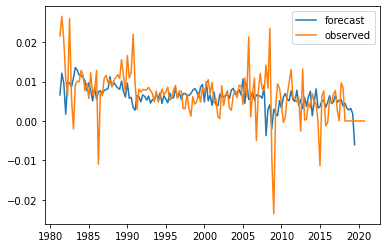

Normality test result: 9.055280209128254e-38


In [117]:
observed_inflation = test_data_log_diff[['inflation']]
step = 4
error = total_squared_error(results,test_data_log_diff, ['inflation','M2','GDP', 'MktCap'], step)
print('Total Error:', error)


forecast = predict(results, test_data_log_diff,['inflation','M2','GDP', 'MktCap'], step)
plt.plot(forecast, label = 'forecast')
plt.plot(observed_inflation, label = 'observed')
plt.legend()
plt.show()

residuals = (observed_inflation.values[:observed_inflation.shape[0] - step - 1] - forecast.values)
print('Normality test result:', kstest(residuals, 'norm')[1])

## VAR: inlfation, M2, GDP, MV2, MktCap

In [281]:
model = VAR(test_data_log_diff[['inflation','M2','GDP', 'M2V', 'MktCap']])
results = model.fit(4)
results.summary()

/home/felipe-fp/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 02, Jun, 2021
Time:                     09:06:22
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -41.6247
Nobs:                     155.000    HQIC:                  -42.8490
Log likelihood:           2391.02    FPE:                1.07368e-19
AIC:                     -43.6864    Det(Omega_mle):     5.68811e-20
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.001456         0.001673            0.870           0.384
L1.inflation         0.183980         0.087895            2.093           0.036
L1.M2                0.093399         0.057540            1.

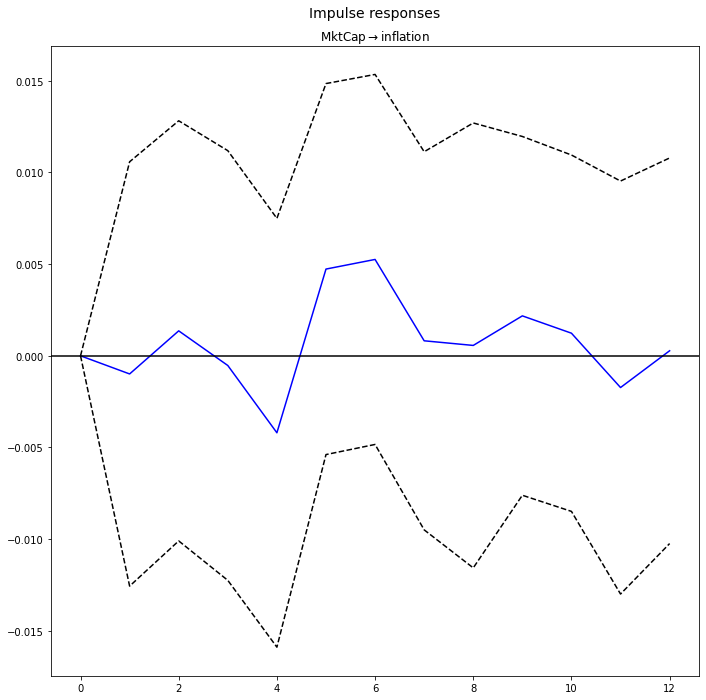

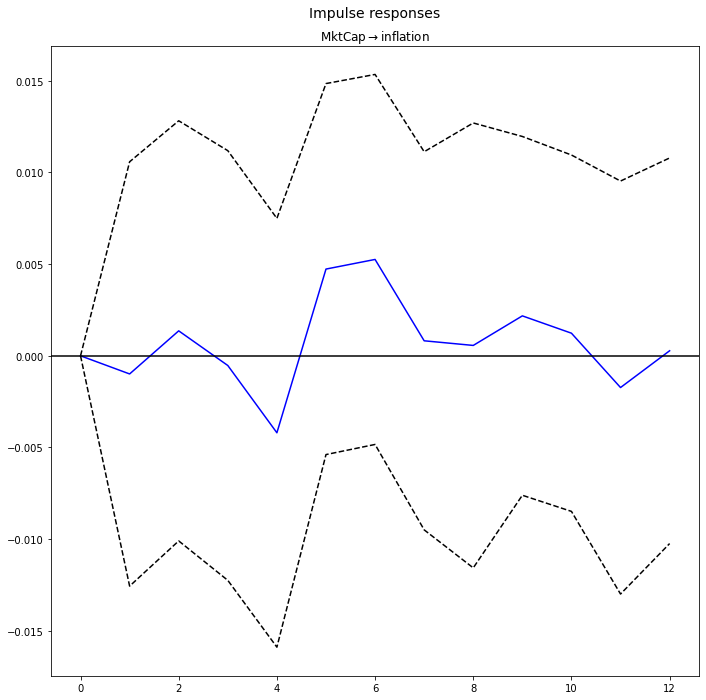

In [287]:
irf = results.irf(12)
irf.plot(impulse = 'MktCap',response = 'inflation')

Total Error: 0.07581252004042058


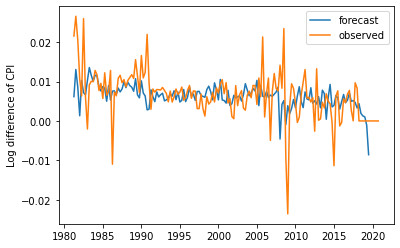

Normality test result: 8.016268199072888e-38


In [278]:
observed_inflation = test_data_log_diff[['inflation']]
step = 4
error = total_squared_error(results,test_data_log_diff, ['inflation','M2','GDP', 'M2V', 'MktCap'], step)
print('Total Error:', error)


forecast = predict(results, test_data_log_diff,['inflation','M2','GDP', 'M2V', 'MktCap'], step)
plt.plot(forecast, label = 'forecast')
plt.plot(observed_inflation, label = 'observed')
plt.legend()
plt.ylabel('Log difference of CPI')
plt.show()

residuals = (observed_inflation.values[:observed_inflation.shape[0] - step - 1] - forecast.values)
print('Normality test result:', kstest(residuals, 'norm')[1])

In [279]:
model = VAR(test_data_log_diff[['inflation','M2','GDP', 'M2V']])
results = model.fit(4)
results.summary()

/home/felipe-fp/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 02, Jun, 2021
Time:                     08:58:38
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -37.5075
Nobs:                     155.000    HQIC:                  -38.3003
Log likelihood:           2198.56    FPE:                1.35638e-17
AIC:                     -38.8427    Det(Omega_mle):     8.94531e-18
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.001492         0.001639            0.910           0.363
L1.inflation         0.180397         0.084883            2.125           0.034
L1.M2                0.090798         0.055514            1.

Total Error: 0.07583900533799943


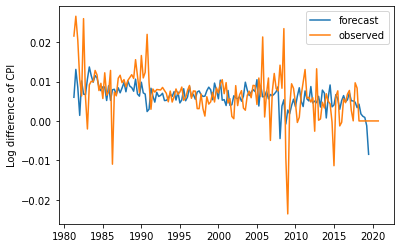

Normality test result: 9.378851158372484e-38


In [280]:
observed_inflation = test_data_log_diff[['inflation']]
step = 4
error = total_squared_error(results,test_data_log_diff, ['inflation','M2','GDP', 'M2V'], step)
print('Total Error:', error)


forecast = predict(results, test_data_log_diff,['inflation','M2','GDP', 'M2V'], step)
plt.plot(forecast, label = 'forecast')
plt.plot(observed_inflation, label = 'observed')
plt.legend()
plt.ylabel('Log difference of CPI')
plt.show()

residuals = (observed_inflation.values[:observed_inflation.shape[0] - step - 1] - forecast.values)
print('Normality test result:', kstest(residuals, 'norm')[1])

In [68]:
data_shifted = test_data_log_diff[['M2', 'GDP', 'M2V']].shift(-1)
data_reg = data_shifted.join(test_data_log_diff['inflation'], how = 'inner').dropna()
model = ols("inflation ~ M2 + M2V + GDP", data_reg).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inflation   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.6409
Date:                Fri, 28 May 2021   Prob (F-statistic):              0.590
Time:                        09:05:58   Log-Likelihood:                 580.08
No. Observations:                 158   AIC:                            -1152.
Df Residuals:                     154   BIC:                            -1140.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0062      0.001      4.820      0.000       0.004       0.009
M2            -0.0252      0.050     -0.501      0.617      -0.124       0.074
M2V           -0.0090      0.050     -0.180      0.858      -0.108       0.090
GDP            0.0644      0.083      0.777      0.438      -0.099       0.228
==============================================================================
Omnibus:                       24.111   Durbin-Watson:                   1.376
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.861
Skew:                          -0.220   Prob(JB):                     1.04e-28
Kurtosis:                       7.402   Cond. No.                         193.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""